# Imports and Constants

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn import model_selection
from matplotlib import pyplot as plt

import PIL
# https://github.com/tensorflow/tensorflow/issues/46840
# https://stackoverflow.com/a/68239032/12405558
if PIL.__version__ == "8.3.0":
    raise ImportError(f"PIL 8.3.0 is incompatible with tensorflow 2.6.0")
    
abspath_join = lambda a, *p: os.path.abspath(os.path.join(a, *p))

BASE_DATA_DIR = "./data"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "train")
TEST_DIR = os.path.join(BASE_DATA_DIR, "test")

BASE_OUTPUT_DIR = "/output"

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

# Split training into training and validation dataset
VALIDATION_SIZE = 0.2

BATCH_SIZE = 32
EPOCHS = 40

CAT_TO_BIN = {"cat": 0, "dog": 1}
BIN_TO_CAT = {v: k for (k, v) in CAT_TO_BIN.items()}

# Prepare Training Data

## Setup for Google Colab

In [2]:
try:
    from google.colab import drive
    from zipfile import ZipFile
    
    MOUNT = "/content/drive"
    drive.mount(MOUNT, force_remount=True)

    BASE_DATA_DIR = "/content/data"
    TRAIN_DIR = abspath_join(BASE_DATA_DIR, "train")
    TEST_DIR = abspath_join(BASE_DATA_DIR, "test1")
    BASE_OUTPUT_DIR = "/content/output"
    for zip_name in ("test1.zip","train.zip"):
        try:
            zip_dir = abspath_join(MOUNT, "MyDrive/AI/data", zip_name)
            with ZipFile(zip_dir, "r") as zip_ref:
                print(f"Unzipping {zip_name}")
                zip_ref.extractall(BASE_DATA_DIR)
        except:
            print(f"{zip_name} not found")
except ImportError:
    pass

## Setup for Kaggle

In [3]:
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', None):
    from glob import glob
    from zipfile import ZipFile
    
    BASE_DATA_DIR = "/kaggle/working/data"
    TRAIN_DIR = abspath_join(BASE_DATA_DIR, "train")
    TEST_DIR = abspath_join(BASE_DATA_DIR, "test1")
    BASE_OUTPUT_DIR = "/kaggle/working"
    print('Extracting the data from dataset...')
    zip_files = glob('/kaggle/input/dogs-vs-cats/*.zip')
    print(f'{len(zip_files)} files found in the input directory')
    for file in zip_files:
        print(f"Unzipping {file.split('/')[-1]}")
        with ZipFile(file, 'r') as Z:
            Z.extractall('data')
        print("Done")

Extracting the data from dataset...
2 files found in the input directory
Unzipping test1.zip
Done
Unzipping train.zip
Done


In [4]:
train_set = os.listdir(TRAIN_DIR)
types = [filename.split(".")[0] for filename in train_set]
df = pd.DataFrame({"filename": train_set, "class": types})
# https://scikit-learn.org/stable/glossary.html#term-random_state
train_df, val_df = model_selection.train_test_split(df, test_size=VALIDATION_SIZE, random_state=42)

TOTAL_TRAIN = train_df.shape[0]
TOTAL_VAL = val_df.shape[0]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

len(train_set)

25000

## Some samples

In [5]:
df["class"].value_counts() #.rename({v: k for k, v in TYPE.items()})

dog    12500
cat    12500
Name: class, dtype: int64

In [6]:
print(f"Training: {len(train_df)}")
train_df["class"].value_counts()

Training: 20000


dog    10006
cat     9994
Name: class, dtype: int64

In [7]:
print(f"Validation: {len(val_df)}")
val_df["class"].value_counts()

Validation: 5000


cat    2506
dog    2494
Name: class, dtype: int64

# Build Model

In [8]:
from tensorflow.keras import models, layers, losses, optimizers

# https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
# https://stackoverflow.com/questions/46036522/defining-model-in-keras-include-top-true
CONV2D_PARAMS = {
    "kernel_size": (3, 3),
    # "padding": "same",
    "activation": "relu",
}
MAXPOOL2D_PARAMS = {
    "pool_size": (2, 2),
    # "strides": (2, 2),
}

model = models.Sequential()
model.add(layers.Input(shape=IMG_SHAPE))
model.add(layers.Conv2D(32, **CONV2D_PARAMS))
model.add(layers.Conv2D(32, **CONV2D_PARAMS))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, **CONV2D_PARAMS))
model.add(layers.Conv2D(64, **CONV2D_PARAMS))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, **CONV2D_PARAMS))
model.add(layers.Conv2D(128, **CONV2D_PARAMS))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, **CONV2D_PARAMS))
# model.add(layers.Conv2D(256, **CONV2D_PARAMS))
# model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=["accuracy"],
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 27, 128)       7

## Model diagram

In [9]:
# keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Data Preprocessing

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATAGEN_PARAMS = {
    "rescale": 1.0 / 255,
    "horizontal_flip": True,
    "zoom_range": 0.1,
    "rotation_range": 35,
    "height_shift_range": 0.2,
    "width_shift_range": 0.2,
}
GEN_PARAMS = {
    "directory": TRAIN_DIR,
    "target_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "class_mode": "categorical",
}

train_datagen = ImageDataGenerator(**DATAGEN_PARAMS)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_dataframe(train_df, **GEN_PARAMS)
val_gen = val_datagen.flow_from_dataframe(val_df, **GEN_PARAMS)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Here we take an image and see how our `ImageDataGenerator` augment the image for each epoch (assume that `steps_per_epoch=TOTAL_TRAIN // BATCH_SIZE`)    

Detail here: https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset

Found 1 validated image filenames belonging to 1 classes.


,index,filename,class
0,13090,cat.10283.jpg,cat


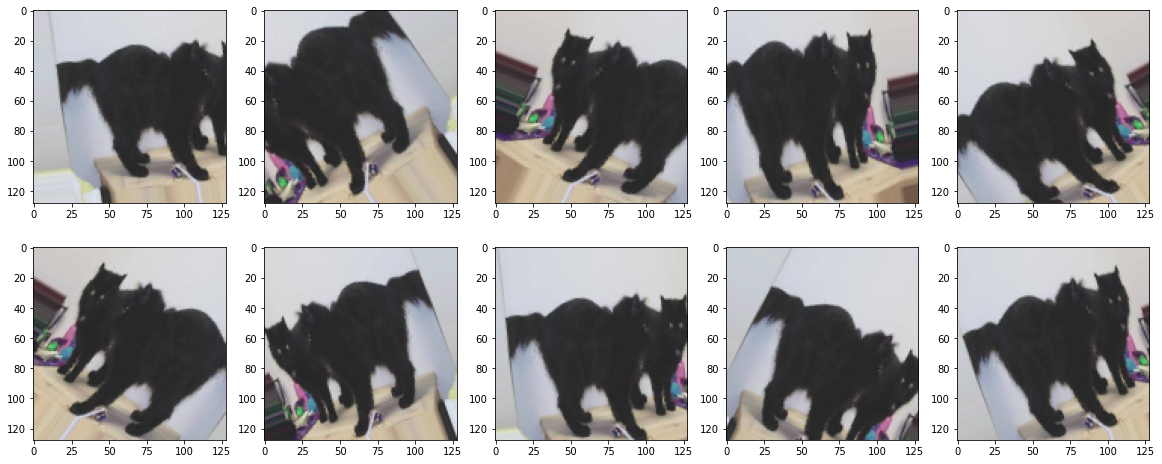

In [11]:
GEN_PARAMS.pop("class_mode", None)
SHAPE = (2, 5)
FIGSIZE = (20, 8)
IMG_IDX = None
if IMG_IDX is None: # Pick random
    sample_df = train_df.sample(n=1).reset_index()
else:
    sample_df = train_df.loc[[IMG_IDX], :]
sample_gen = train_datagen.flow_from_dataframe(
    sample_df,
    **GEN_PARAMS,
)

fig = plt.figure(figsize=FIGSIZE)
for i in range(0, SHAPE[0]*SHAPE[1]):
    fig.add_subplot(SHAPE[0], SHAPE[1], i + 1)
    x_batch, _ = next(sample_gen)
    image = x_batch[0]
    plt.imshow(image)
display(sample_df)
plt.show()


# Training

In [12]:
from tensorflow.keras import callbacks
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
lr_reduction = callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.5
)
filepath = abspath_join(
    BASE_OUTPUT_DIR, "checkpoint_{epoch:02d}_{val_accuracy:.2f}.hdf5"
)
# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = callbacks.ModelCheckpoint(
    filepath, monitor="val_accuracy", verbose=1, save_best_only=True
)
early_stop_val_loss = callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)
early_stop_val_acc = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)

In [13]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    steps_per_epoch=len(train_gen),
    callbacks=[early_stop_val_acc, checkpoint],
)

Epoch 1/40
625/625 [==============================] - 143s 217ms/step - loss: 0.6724 - accuracy: 0.5679 - val_loss: 0.5959 - val_accuracy: 0.6790

Epoch 00001: val_accuracy improved from -inf to 0.67900, saving model to /kaggle/working/checkpoint_01_0.68.hdf5
Epoch 2/40
625/625 [==============================] - 134s 214ms/step - loss: 0.6107 - accuracy: 0.6669 - val_loss: 0.5416 - val_accuracy: 0.7278

Epoch 00002: val_accuracy improved from 0.67900 to 0.72780, saving model to /kaggle/working/checkpoint_02_0.73.hdf5
Epoch 3/40
625/625 [==============================] - 134s 215ms/step - loss: 0.5672 - accuracy: 0.7086 - val_loss: 0.4951 - val_accuracy: 0.7640

Epoch 00003: val_accuracy improved from 0.72780 to 0.76400, saving model to /kaggle/working/checkpoint_03_0.76.hdf5
Epoch 4/40
625/625 [==============================] - 135s 215ms/step - loss: 0.5356 - accuracy: 0.7302 - val_loss: 0.4564 - val_accuracy: 0.7848

Epoch 00004: val_accuracy improved from 0.76400 to 0.78480, saving 

## Save Model

In [14]:
model.save_weights(abspath_join(BASE_OUTPUT_DIR, "model_weight"))
model.save(abspath_join(BASE_OUTPUT_DIR, "model"))
model.save_weights("model_weight1.h5")
model.save("model1.h5")
# history.history['accuracy']
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.655284,0.60730,0.595901,0.6790
1,0.600648,0.67510,0.541586,0.7278
2,0.563568,0.71290,0.495066,0.7640
3,0.533109,0.73240,0.456425,0.7848
4,0.511141,0.74700,0.459073,0.7848
5,0.494751,0.76310,0.417912,0.8078
6,0.477304,0.77230,0.385578,0.8316
7,0.453909,0.78945,0.390358,0.8302
8,0.432278,0.80300,0.381926,0.8236
9,0.412431,0.80990,0.356563,0.8408


# Virtualize Training

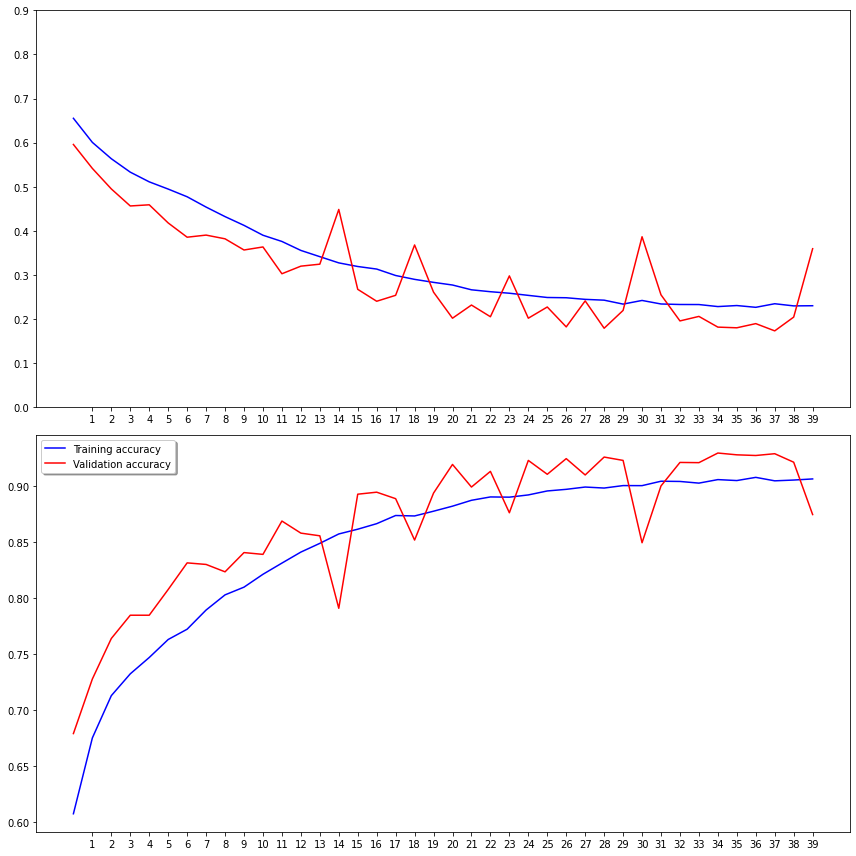

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Load test data

In [16]:
test_set = os.listdir(TEST_DIR)
test_df = pd.DataFrame({"filename": test_set})

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_gen = test_datagen.flow_from_dataframe(
    test_df,
    TEST_DIR,
    target_size=IMG_SIZE,
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 12500 validated image filenames.


# Predict

In [17]:
predict = model.predict(test_gen, verbose=1)

391/391 [==============================] - 31s 80ms/step


<AxesSubplot:>

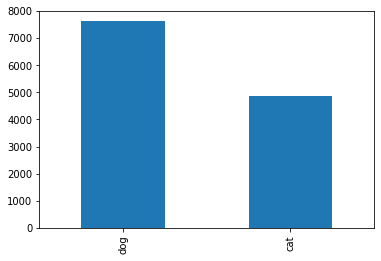

In [18]:
test_df["class"] = np.argmax(predict, axis=-1)
result_df = test_df.copy()
result_df["class"] = test_df["class"].replace(BIN_TO_CAT)
result_df["class"].value_counts().plot.bar()

# Prediction Samples

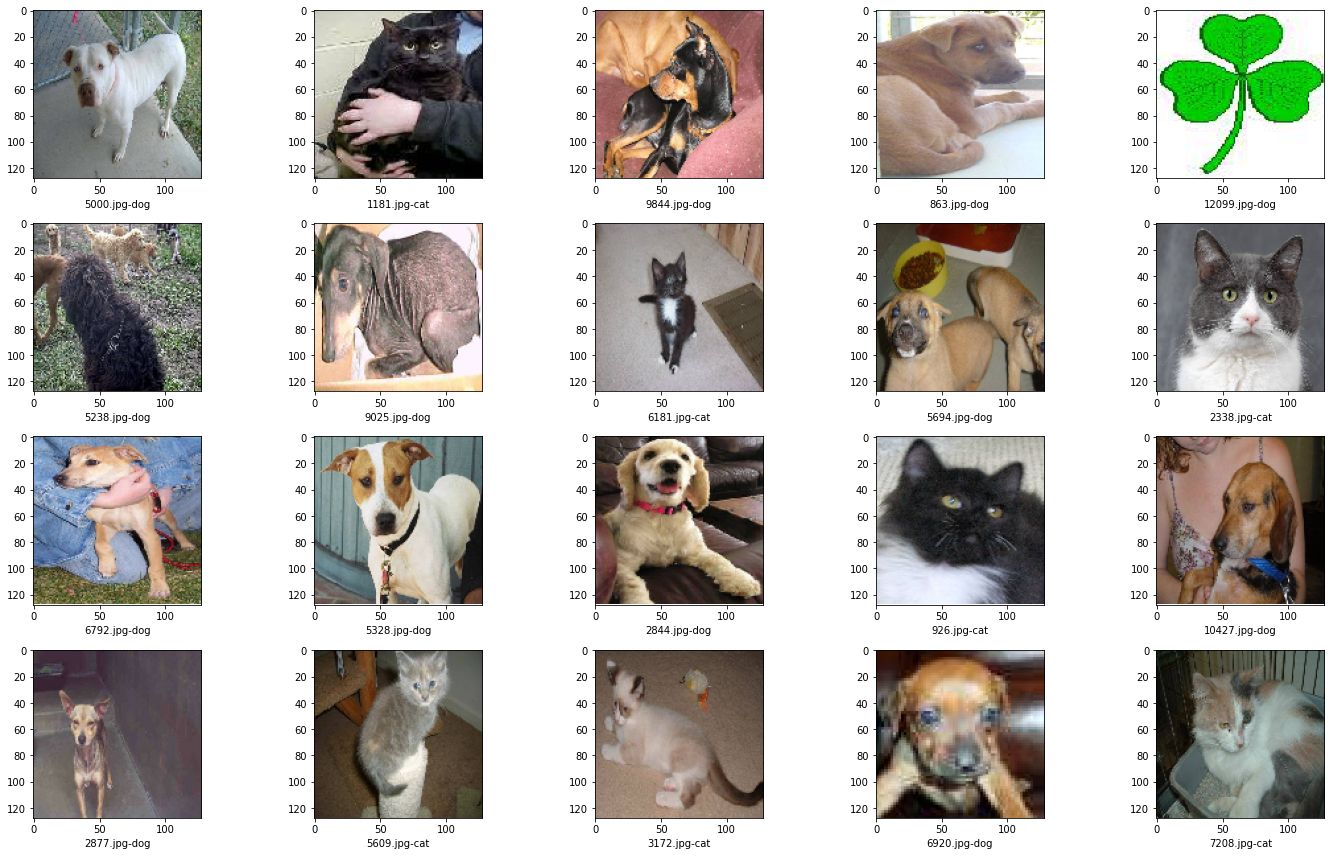

In [19]:
from tensorflow.keras.preprocessing.image import load_img

SHAPE = (4, 5)
FIGSIZE = (20, 12)
N = SHAPE[0] * SHAPE[1]

sample_df = result_df.sample(n=N).reset_index(drop=True)
plt.figure(figsize=FIGSIZE)
for i, row in sample_df.iterrows():
    filename = row["filename"]
    filepath = os.path.join(TEST_DIR, filename)
    type = row["class"]
    image = load_img(filepath, target_size=IMG_SIZE)
    plt.subplot(SHAPE[0], SHAPE[1], i + 1)
    plt.imshow(image)
    plt.xlabel(f"{filename}-{type}")
plt.tight_layout()
plt.show()
